In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pkg_resources

from debvader.model import load_deblender
from debvader.deblender import deblend, DeblendField
from debvader.detection import detect_objects

2023-09-13 18:42:28.194084: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-13 18:42:28.195463: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-13 18:42:28.226742: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-13 18:42:28.227200: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-13 18:42:28.913255: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

### Deblend stamps randomly generated from DC2 data

Load 10 DC2 images centred on galaxy. They have been generated using this notebook: https://github.com/BastienArcelin/dc2_img_generation/blob/main/notebooks/dc2_stamps_and_corresponding_parameters.ipynb

In [2]:
data_path = pkg_resources.resource_filename('debvader', "data/")
image_path = os.path.join(data_path + '/dc2_imgs/imgs_dc2.npy')
images = np.load(image_path, mmap_mode = 'c')

Visualize some of the images

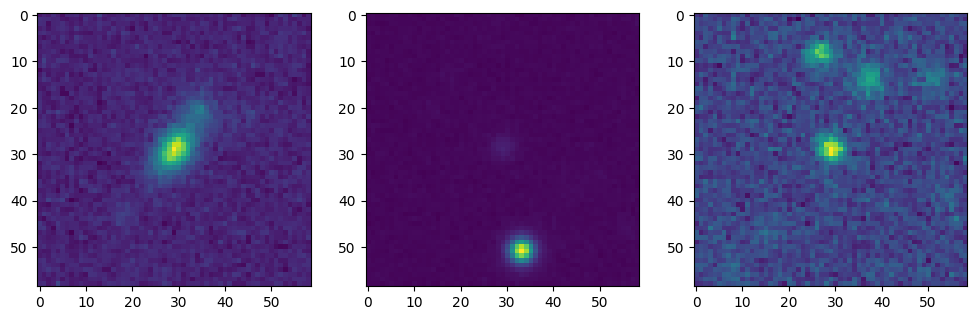

In [3]:
fig, axes = plt.subplots(1,3, figsize = (12, 4))
for i in range (3):
    axes[i].imshow(images[i,:,:,2]) # We plot only r-band here, but the images are multi-bands (ugrizy)

Now we can load the deblender

In [4]:
# First, define the parameters of the neural network, for this version of debvader, they are as follow:
nb_of_bands = 6
input_shape = (59, 59, nb_of_bands)
latent_dim = 32
filters = [32,64,128,256]
kernels = [3,3,3,3]

# We will load the weights of the network trained on DC2 images
survey = "dc2"

In [5]:
net, encoder, decoder, z = load_deblender(
    survey, input_shape, latent_dim, filters, kernels, return_encoder_decoder_z=True,
    for_onnx=True)

in cropping
/home/junpenglao/OSS/debvader/src/debvader/data/weights/dc2/not_normalised/loss


In [6]:
# We can visualize the network
net.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 59, 59, 6)]          0         []                            
                                                                                                  
 model (Functional)          (None, 560)                  3741224   ['input_3[0][0]']             
                                                                                                  
 tf.__operators__.getitem_2  (None, 528)                  0         ['model[0][0]']               
  (SlicingOpLambda)                                                                               
                                                                                                  
 tf.convert_to_tensor (TFOp  (None, 528)                  0         ['tf.__operators__.getit

We now have everything to do the deblending. Let's use our network to deblend the DC2 images

In [7]:
def deblend_onnx(net, images, normalised=False):
    """
    Deblend the image using the network
    parameters:
        net: neural network used to do the deblending
        images: array of images. It can contain only one image
        normalised: boolean to indicate if images need to be normalised
    """
    if normalised:
        # Normalize input images
        images_normed = np.tanh(np.arcsinh(images))
        # Denorm output images
        images = np.sinh(np.arctanh(net.predict(images_normed)))

    return net(tf.cast(images, tf.float32))

output_images_sample = deblend_onnx(net, images)

Here the network outputs a distribution over the pixels for each pixel in each filter, this is why both the mean image and the corresponding distribution is outputed.

Let's first visualize the mean images outputed by debvader.

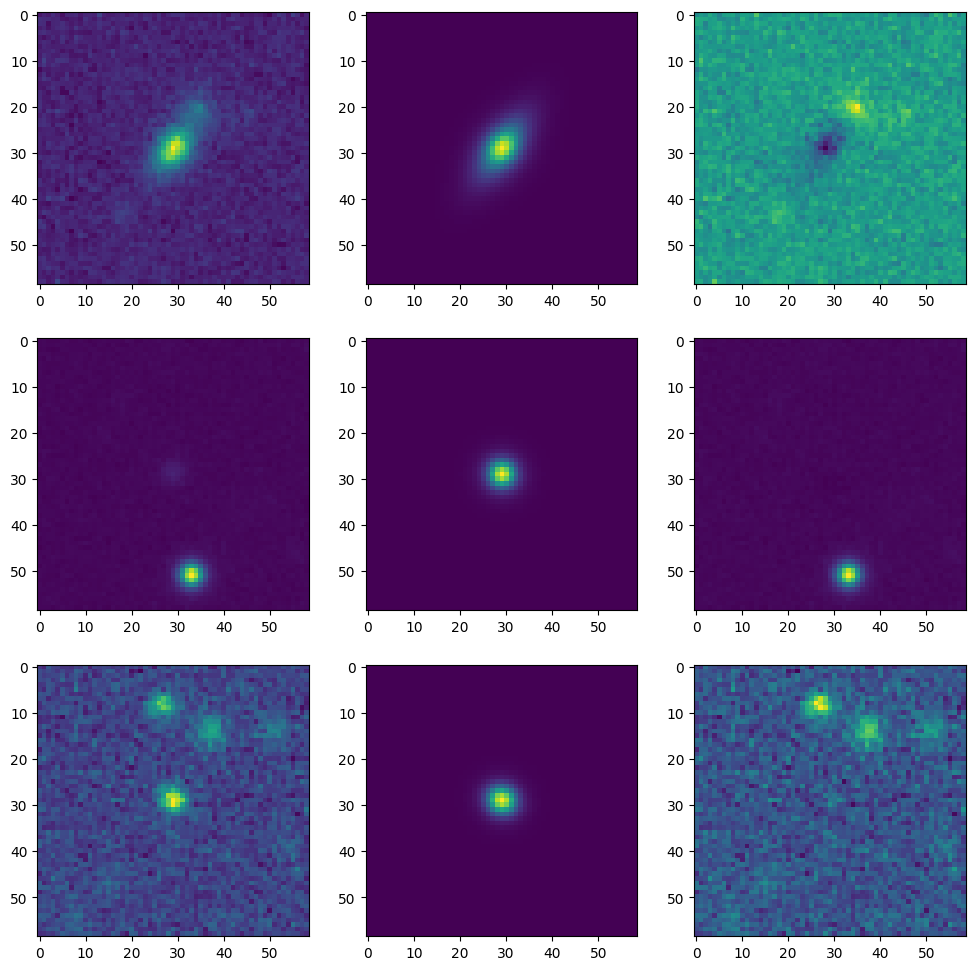

In [8]:
fig, axes = plt.subplots(3,3, figsize = (12, 12))
for i in range (3):
    axes[i,0].imshow(images[i,:,:,2]) # We plot only r-band here, but the images are multi-bands (ugrizy)
    axes[i,1].imshow(output_images_sample[i,:,:,2]) # We plot only r-band here, but the output images are multi-bands (ugrizy)
    axes[i,2].imshow(images[i,:,:,2]-output_images_sample[i,:,:,2])

Now we can look at what the images of the standard deviation look like for each example, and how we can sample this distribution in each pixel.

In [10]:
import tf2onnx
import onnx
import onnxruntime as ort
input_signature = [tf.TensorSpec([None, *input_shape], tf.float32, name='x')]
# Use from_function for tf functions
onnx_model, _ = tf2onnx.convert.from_keras(net, input_signature, opset=18)
onnx.save(onnx_model, "../onnx/net.onnx")

Could not search for non-variable resources. Concrete function internal representation may have changed.
2023-09-13 18:42:54.279504: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2023-09-13 18:42:54.279650: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2023-09-13 18:42:55.271764: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2023-09-13 18:42:55.271912: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
ONNX Failed to infer shapes and dtypes for [Loop__372, type: Loop]
Traceback (most recent call last):
  File "/home/junpenglao/miniconda3/envs/astrodeep/lib/python3.11/site-packages/tf2onnx/schemas.py", line 154, in infer_onnx_shape_dtype
    inferred_model = shape_inference.infer_shapes(model_proto, strict_mode=True)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [22]:
import onnxruntime as ort
import numpy as np
# Change shapes and types to match model
input1 = np.zeros((20, *input_shape), np.float32)

# Start from ORT 1.10, ORT requires explicitly setting the providers parameter if you want to use execution providers
# other than the default CPU provider (as opposed to the previous behavior of providers getting set/registered by default
# based on the build flags) when instantiating InferenceSession.
# Following code assumes NVIDIA GPU is available, you can specify other execution providers or don't include providers parameter
# to use default CPU provider.
sess = ort.InferenceSession(
    "../onnx/net.onnx", 
    # providers=["CUDAExecutionProvider"]
    )
# Set first argument of sess.run to None to use all model outputs in default order
# Input/output names are printed by the CLI and can be set with --rename-inputs and --rename-outputs
# If using the python API, names are determined from function arg names or TensorSpec names.
results_ort = sess.run(
    net.output_names, 
    {"x": tf.cast(images, tf.float32).numpy()
     })[0]

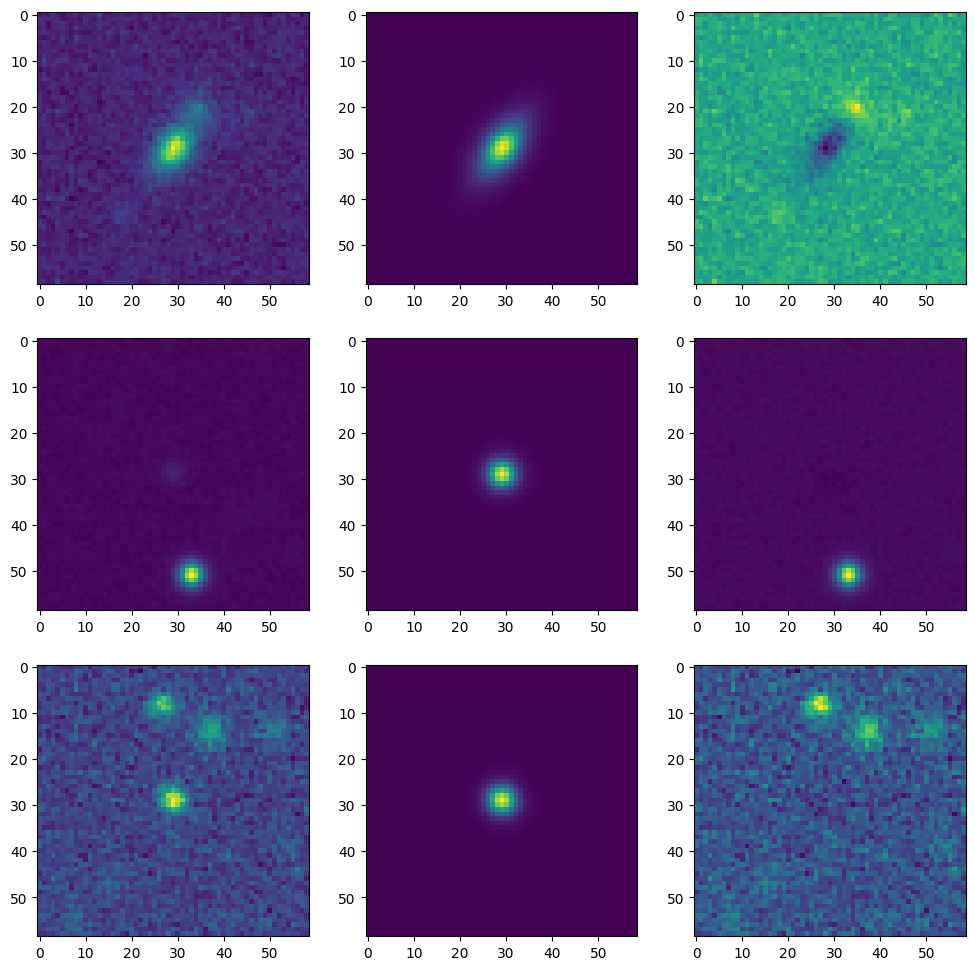

In [23]:
fig, axes = plt.subplots(3,3, figsize = (12, 12))
for i in range (3):
    axes[i,0].imshow(images[i,:,:,2]) # We plot only r-band here, but the images are multi-bands (ugrizy)
    axes[i,1].imshow(results_ort[i,:,:,2]) # We plot only r-band here, but the output images are multi-bands (ugrizy)
    axes[i,2].imshow(images[i,:,:,2]-results_ort[i,:,:,2])